### SISTEMA DE RECOMENDACIÓN POR FILTRO COLABORATIVO

El presente trabajo tiene por objetivo contrastar los resultados obtenidos en el sistema de recomendación creado en el sprint 3, para el cual se utilizó el método SVD, con los resultantes del sistema de recomendación por filtro colaborativo a desarrollar en el presente notebook. La hipotesis de trabajo es que si bien las metodologías no son analogas, se deberían obtener similares recomendaciones dado que los inputs de los sistemas son iguales. 

A continuación importamos las librerías necesarias para llevar a cabo el trabajo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
import gc
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from scipy import stats
import pandas as pd
import gzip
from sklearn.preprocessing import OneHotEncoder


Levantamos las bases de datos

In [2]:
data_reviews=pd.read_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews22.csv')
data_reviews.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [4]:
data_games = []
for l in parse('C:\\Users\\Usuario\\source\\repos\\steam_games.json.gz'):
        data_games.append(l)

In [5]:
data_games = pd.DataFrame(data_games)

### DESCRIPCIÓN DE FEATURES INCLUIDOS EN DATA_REVIEWS

**username:** Nombre del usuario que ha dejado la reseña

**hours:** Cantidad de horas jugadas (acumuladas) en el juego al cual se le ha hecho la reseña

**products:** Cantidad de otros juegos probados

**product_id:** Identificacion númerica del juego reseñado

**page:** Número de página en el cual se encuentra el juego dentro de la plataforma

**date:** Fecha en la cual se ha creado la reseña

**text:** Comentario sobre el juego

**early_access:** Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

**page_order:** No es interpretable

**user_id:** Identificacion númerica del usuario creador de la reseña

**found_funny:** Cantidad de calificaciones positivas creadas por otros usuarios

**compensation:** Variable no interpretable dada la cantidad de valores nulos contenidos en ella

### ANALISIS EXPLORATORIO DATA_REVIEWS

In [6]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,MR_SERENITY,14.8,147.0,35140,2,2018-01-03,aweosme game great story and some epic moments...,False,1,NaN,NaN,7.656120e+16
1,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
2,The Undead StalkeR,17.0,87.0,35140,5,2018-01-03,9/10\nEven after all these years. this game re...,False,1,NaN,NaN,7.656120e+16
3,Mono,14.1,54.0,506510,1,2017-12-27,A Charming game with colourful pixel graphics ...,False,1,NaN,NaN,7.656120e+16
4,Uncle-Noob,24.7,37.0,350280,3,2018-01-04,"I really like this game, but no one plays it. ...",False,1,NaN,NaN,NaN


In [7]:
data_reviews.shape

(2227331, 12)

In [8]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227331 entries, 0 to 2227330
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   hours         float64
 2   products      float64
 3   product_id    int64  
 4   page_order    int64  
 5   date          object 
 6   text          object 
 7   early_access  bool   
 8   page          int64  
 9   found_funny   float64
 10  compensation  object 
 11  user_id       float64
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 189.0+ MB


In [9]:
data_reviews.isna().sum()

username              0
hours                 0
products              0
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     1926643
compensation    2196894
user_id         1249261
dtype: int64

In [10]:
data_reviews.drop(['user_id','compensation','found_funny'],axis=1,inplace=True)

**Respondemos algunas preguntas:**

*¿Cual es el promedio de horas jugadas por jugador?*

In [11]:
data_reviews.hours.mean()

35.44001803054945

*¿Cual es el jugador que mas horas jugó a un juego? ¿y el que menos?*

In [12]:
data_reviews.loc[:,['hours','username']].max()

hours              99.9
username    󰀖Mr.Tarunio
dtype: object

In [13]:
data_reviews.loc[:,['hours','username']].min()

hours       10.1
username       !
dtype: object

*¿Que cantidad de juegos, prueban en promedio los usuarios?*

In [14]:
data_reviews.products.mean()

116.34962966887275

*¿Cual es el usuario que más juegos probó? y el que menos?*

In [15]:
data_reviews.loc[:,['username','products']].max()

username    󰀖Mr.Tarunio
products          299.0
dtype: object

In [16]:
data_reviews.loc[:,['username','products']].min()

username       !
products    21.0
dtype: object

*¿Se puede afirmar que, existe una alta correlación entre horasy juegos probados?*

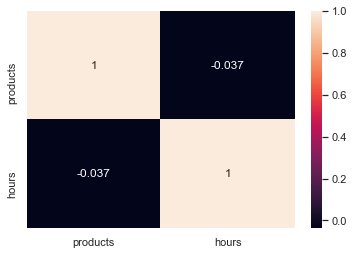

In [17]:
correlacion1=data_reviews.loc[:,['products','hours']].corr()
sns.heatmap(correlacion1,cbar=True,annot=True)

Claramente no se puede afirmar que a mayor cantidad de productos probados, mayor cantidad de horas jugadas. La explicación radica en que la variable 'hours' hace referencia a las horas destinadas por el usuario al juego en el cual dejó su review, por ende, tiene sentido que cuantas mas horas haya dedicado al juego en el cual dejó su reseña menos horas haya podido destinar a otros juegos y de allí que existe una correlación negativa entre ambas variables

*¿La ubicación del juego dentro de la plataforma, tiene alguna injerencia para los usuarios?*

In [18]:
data_reviews.page.value_counts()

1        15507
2        14248
3        13112
4        12262
5        11834
         ...  
7826         1
15316        1
15317        1
11210        1
11103        1
Name: page, Length: 15900, dtype: int64

In [19]:
data_reviews[data_reviews.page<10].shape[0]/data_reviews.shape[0]*100

4.89945140618974

In [20]:
data_reviews.page.value_counts().plot

In [21]:
conteo=data_reviews.page.value_counts()>10


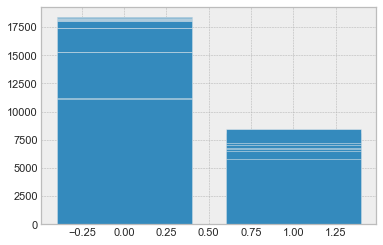

In [22]:
plt.style.use("bmh")
plt.bar(conteo, conteo.index)            # Crear gráfico
plt.show()                               # Mostrar gráfico
plt.close('all')  

In [23]:
data_games

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN


In [24]:
lista_genres=data_games.genres.explode().unique()

In [25]:
lista_genre

NameError: name 'lista_genre' is not defined

In [ ]:
specs_list=data_games.specs.explode().unique()
specs_list

In [ ]:
tags_list=data_games.tags.explode().unique()

In [ ]:
clean_tags=[]
for i in tags_list:
    if (not i in lista_genres)&(not i in specs_list):
        clean_tags.append(i)
clean_tags        
print(len(clean_tags))
print(len(tags_list))

In [ ]:
data_games['clean_tags']=''

In [ ]:
for tags in data_games.tags:
    dropped_list=[]
    for tag in tags:
        if tag in clean_tags:
            dropped_list.append(tag)
    tag.clean_tags=dropped_list
    

In [ ]:
n_usuarios=len(data_rev.reset_index(drop=True).iloc[0:1000])
n_items=len(data_games.id)
usuarios=data_rev.iloc[0:1000].username
items=data_games.id

In [ ]:
user=data_reviews_ok.username.value_counts()[data_reviews_ok.username.value_counts()>3].index
items=title_id.id.unique()
n_user=len(user)
n_items=len(items)

In [ ]:
matriz_utilidad=pd.DataFrame(np.zeros((n_user,n_items)), index=user, columns=items).astype(pd.SparseDtype('float'))
matriz_utilidad

In [ ]:
for column in matriz_utilidad:
    spdtypes=matriz_utilidad.dtypes[column]
    
    matriz_utilidad[column] = matriz_utilidad[column].sparse.to_dense()
    
    
    mask_calif_columns=items==column
    calificaciones_column=data_reviews_ok.username.value_counts()[data_reviews_ok.username.value_counts()>3]
    
    
    matriz_utilidad[column].loc[calificaciones_column.index]=calificaciones_column
    